In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import gurobipy as gb

In [2]:
from customer import Customer
from locker_customer import LockerCustomer
from door_to_door_customer import DoorToDoorCustomer
from location import Location
from store import *
from vehicle import Vehicle
from vehicle_type import VehicleType

In [3]:
# input
custom_setup = False
C = 15
L = 3

map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [4]:
def get_nearest_store(stores, location):
    min_distance = float("inf")
    nearest_store = stores[0]
    for store in stores:
        distance = location.euclidean_distance(store.location)
        if distance < min_distance:
            min_distance = distance
            nearest_store = store
    return nearest_store

In [5]:
# generate data
if custom_setup:
    C = 8
    L = 2
    stores = []
    stores.append(Store(Location(60, 50), capacity=float("inf"), is_warehouse=True))
    stores.append(Store(Location(30, 50), capacity=math.ceil(0.8 * C / L)))
    stores.append(Store(Location(50, 20), capacity=math.ceil(0.8 * C / L)))

    customers = []
    customers.append(LockerCustomer(Location(10, 28), stores[1]))
    customers.append(DoorToDoorCustomer(Location(20, 40), prime=False))
    customers.append(DoorToDoorCustomer(Location(15, 70), prime=False))
    customers.append(DoorToDoorCustomer(Location(30, 70), prime=True))
    customers.append(DoorToDoorCustomer(Location(80, 60), prime=True))
    customers.append(LockerCustomer(Location(70, 40), stores[0]))
    customers.append(DoorToDoorCustomer(Location(90, 50), prime=False))
    customers.append(LockerCustomer(Location(40, 15), stores[2]))
else:
    stores = []
    stores.append(Store(Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=float("inf")))
    for l in range(L):
        stores.append(Store(Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=math.ceil(0.8 * C / L)))

    customers = []
    for c in range(C):
        location = Location(random.randint(0, map_size), random.randint(0, map_size))
        if random.random() < ratio_locker_customers:
            # customer locker
            customers.append(LockerCustomer(location, get_nearest_store(stores, location)))
        else:
            # door to door customer
            if random.random() < ratio_prime_door_to_door_customer:
                customers.append(DoorToDoorCustomer(location, prime=True))
            else:
                customers.append(DoorToDoorCustomer(location, prime=False))

In [6]:
# create sets
C_L = list(filter(lambda customer: type(customer) == LockerCustomer, customers))
C_D = list(filter(lambda customer: type(customer) == DoorToDoorCustomer, customers))
S_k = list(filter(lambda customer: type(customer) == DoorToDoorCustomer and customer.prime == False, customers))
lockers = list(filter(lambda store: not store.is_warehouse, stores))

sum_W_l = 0
for store in stores:
    if not store.is_warehouse:
        sum_W_l += store.capacity

# define all the vehicles
if custom_setup:
    vehicles = []
    vehicles.append(Vehicle(VehicleType.LOCKER_SUPPLY, stores[0], math.ceil(0.8 * sum_W_l)))
    vehicles.append(Vehicle(VehicleType.PF, stores[0], math.ceil(0.5 * len(C_D))))
    vehicles.append(Vehicle(VehicleType.LF, stores[1], math.ceil(0.6 * stores[1].capacity)))
    vehicles.append(Vehicle(VehicleType.LF, stores[2], math.ceil(0.6 * stores[2].capacity)))
else:
    vehicles = []
    for store in stores:
        if store.is_warehouse:
            vehicles.append(Vehicle(VehicleType.LOCKER_SUPPLY, store, math.ceil(0.8 * sum_W_l)))
            vehicles.append(Vehicle(VehicleType.PF, store, math.ceil(0.5 * len(C_D))))
        else:
            vehicles.append(Vehicle(VehicleType.LF, store, math.ceil(0.6 * store.capacity)))

In [7]:
# define some np.array to plot the map
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
S_k_location = np.array([[0,0]])
L_location = np.array([[0,0]])
W_location = np.array([[0,0]])

for store in stores:
    if store.is_warehouse:
        W_location = np.vstack([W_location, [store.location.x, store.location.y]])
    else:
        L_location = np.vstack([L_location, [store.location.x, store.location.y]])
for cd in C_D:
    CD_location = np.vstack([CD_location, [cd.location.x, cd.location.y]])
for cl in C_L:
    CL_location = np.vstack([CL_location, [cl.location.x, cl.location.y]])
for sk in S_k:
    S_k_location = np.vstack([S_k_location, [sk.location.x, sk.location.y]])

S_k_location = np.delete(S_k_location,0,0)
CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)
L_location = np.delete(L_location, 0, 0)
W_location = np.delete(W_location, 0, 0)

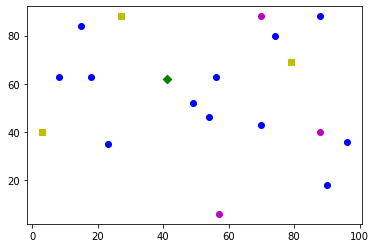

In [8]:
# plot the map
plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

In [9]:
#calcolo la matrice delle distanze:

all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + C_D + C_L

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)


              W         L1         L2         L3        CD0        CD1  \
W      0.000000  38.639358  29.529646  43.908997  65.855903  33.015148   
L1    38.639358   0.000000  55.362442  81.344945  52.172790  71.253070   
L2    29.529646  55.362442   0.000000  53.665631  94.175368  31.400637   
L3    43.908997  81.344945  53.665631   0.000000  89.738509  23.537205   
CD0   65.855903  52.172790  94.175368  89.738509   0.000000  93.536089   
CD1   33.015148  71.253070  31.400637  23.537205  93.536089   0.000000   
CD2   12.806248  34.481879  42.190046  47.539457  53.263496  42.449971   
CD3   53.712196  21.023796  61.000000  97.616597  70.028566  83.815273   
CD4   23.021729  61.294372  26.570661  27.459060  84.905830  10.000000   
CD5   60.835845  37.121422  86.400231  93.085982  18.973666  92.048900   
CD6   34.669872  27.513633  62.241465  67.067131  32.015621  65.145990   
CD7   20.615528  33.970576  49.929951  51.351728  45.607017  49.040799   
CD8   15.033296  23.769729  38.288379 

In [10]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=[stores[0]] + C_D, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=[stores[0]] + C_D, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+C_D, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + C_D, axis=0)
print(LF_distances_matrix)

            W         L1         L2         L3
W    0.000000  38.639358  29.529646  43.908997
L1  38.639358   0.000000  55.362442  81.344945
L2  29.529646  55.362442   0.000000  53.665631
L3  43.908997  81.344945  53.665631   0.000000
              W        CD0        CD1        CD2        CD3        CD4  \
W      0.000000  65.855903  33.015148  12.806248  53.712196  23.021729   
CD0   65.855903   0.000000  93.536089  53.263496  70.028566  84.905830   
CD1   33.015148  93.536089   0.000000  42.449971  83.815273  10.000000   
CD2   12.806248  53.263496  42.449971   0.000000  53.075418  32.893768   
CD3   53.712196  70.028566  83.815273  53.075418   0.000000  74.330344   
CD4   23.021729  84.905830  10.000000  32.893768  74.330344   0.000000   
CD5   60.835845  18.973666  92.048900  49.648766  52.611786  82.540899   
CD6   34.669872  32.015621  65.145990  22.847319  48.466483  55.713553   
CD7   20.615528  45.607017  49.040799   7.810250  54.037024  39.812058   
CD8   15.033296  56.40035

In [11]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)


            W         L1         L2         L3
W    0.000000  28.979519  22.147235  32.931748
L1  28.979519   0.000000  41.521832  61.008708
L2  22.147235  41.521832   0.000000  40.249224
L3  32.931748  61.008708  40.249224   0.000000
              W        CD0        CD1        CD2        CD3        CD4  \
W      0.000000  65.855903  33.015148  12.806248  53.712196  23.021729   
CD0   65.855903   0.000000  93.536089  53.263496  70.028566  84.905830   
CD1   33.015148  93.536089   0.000000  42.449971  83.815273  10.000000   
CD2   12.806248  53.263496  42.449971   0.000000  53.075418  32.893768   
CD3   53.712196  70.028566  83.815273  53.075418   0.000000  74.330344   
CD4   23.021729  84.905830  10.000000  32.893768  74.330344   0.000000   
CD5   60.835845  18.973666  92.048900  49.648766  52.611786  82.540899   
CD6   34.669872  32.015621  65.145990  22.847319  48.466483  55.713553   
CD7   20.615528  45.607017  49.040799   7.810250  54.037024  39.812058   
CD8   15.033296  56.40035

In [12]:

LF_delivery_cost_multidim = np.zeros((L,len(C_D)+1,len(C_D)+1))

for i in range(L):
    l = [0]
    l[0]=lockers[i]
    ls = LF_delivery_cost.filter(items=l+C_D,axis=1)
    ls = ls.filter(items=l+C_D,axis=0)
    print(ls)
    lt = ls.to_numpy()
    for j in range(1+len(C_D)):
        for k in range(1+len(C_D)):
            LF_delivery_cost_multidim[i][j][k]=lt[j][k]


             L1        CD0        CD1        CD2        CD3        CD4  \
L1     0.000000  44.346871  60.565110  29.309597  17.870227  52.100216   
CD0   44.346871   0.000000  79.505676  45.273972  59.524281  72.169956   
CD1   60.565110  79.505676   0.000000  36.082475  71.242982   8.500000   
CD2   29.309597  45.273972  36.082475   0.000000  45.114105  27.959703   
CD3   17.870227  59.524281  71.242982  45.114105   0.000000  63.180792   
CD4   52.100216  72.169956   8.500000  27.959703  63.180792   0.000000   
CD5   31.553209  16.127616  78.241565  42.201451  44.720018  70.159764   
CD6   23.386588  27.213278  55.374091  19.420221  41.196511  47.356520   
CD7   28.874989  38.765964  41.684679   6.638712  45.931471  33.840250   
CD8   20.204269  47.940301  40.800000  11.082644  34.516699  32.300000   
CD9   10.270589  54.426556  57.931101  31.906151  13.705838  49.744975   
CD10  55.686354  58.754617  27.000046  26.404782  71.288604  24.176487   
CD11  55.874167  84.919212  18.815552 

In [13]:
#compensation

compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

#define indexes for the subset S_k
S_k_indexes = []
for s in range(len(S_k_location)):
    S_k_indexes.append("Sk"+str(s))

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


distance_matrix_customer_locker_store = dist_matrix.filter(items=C_L,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)
print(distance_matrix_customer_locker_store)


closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print(closest_store_to_CL)

index_close_locker = []
for i in range(len(closest_store_to_CL)):
    index_close_locker.append(closest_store_to_CL[i])
print(index_close_locker)


# TODO matrix layout to reformat
d_ak_c = compensation_matrix.filter(items = S_k_indexes,axis=1)
d_ak_c=d_ak_c.filter(items=index_close_locker,axis=0)
print(d_ak_c)

ro = 0.5
compensation_matrix_cost = ro*d_ak_c
print(compensation_matrix_cost)
compensation_matrix_cost_multidim = compensation_matrix_cost.to_numpy()
print(compensation_matrix_cost_multidim)



             W         L1         L2         L3        Sk0        Sk1  \
W     0.000000  38.639358  29.529646  43.908997  65.855903  33.015148   
L1   38.639358   0.000000  55.362442  81.344945  52.172790  71.253070   
L2   29.529646  55.362442   0.000000  53.665631  94.175368  31.400637   
L3   43.908997  81.344945  53.665631   0.000000  89.738509  23.537205   
Sk0  65.855903  52.172790  94.175368  89.738509   0.000000  93.536089   
Sk1  33.015148  71.253070  31.400637  23.537205  93.536089   0.000000   
Sk2  12.806248  34.481879  42.190046  47.539457  53.263496  42.449971   
Sk3  53.712196  21.023796  61.000000  97.616597  70.028566  83.815273   
Sk4  23.021729  61.294372  26.570661  27.459060  84.905830  10.000000   
Sk5  34.669872  27.513633  62.241465  67.067131  32.015621  65.145990   
Sk6  15.033296  23.769729  38.288379  57.775427  56.400355  48.000000   
Sk7  37.589892  12.083046  47.675990  81.492331  64.031242  68.154237   

           Sk2        Sk3        Sk4        Sk5   

In [14]:
for s in stores:
    print(s.find_associated_CL(customers, stores))


[]
[CL1, CL2]
[]
[]


In [15]:
'''
def find_closest_Cl_to_locker(i):
    only_cl_close_to_l_i=[]
    counter = 0
    for j in range(len(index_close_locker)):
        if lockers[i] == index_close_locker[j]:
            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)
            counter = counter+1
    #only_cl_close_to_l_i = only_cl_close_to_l_i.astype(int)
    return only_cl_close_to_l_i

def find_q_array_for_closest_cl_to_locker(i):
    q_cl_close_to_locker_i=[]
    only_cl_close_to_l_i=[]
    counter = 0
    for j in range(len(index_close_locker)):
        if lockers[i] == index_close_locker[j]:
            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)
            counter = counter+1

    q_cl_close_to_locker_i = np.ones(counter)
    q_cl_close_to_locker_i=q_cl_close_to_locker_i.astype(int)
    return q_cl_close_to_locker_i
'''

'\ndef find_closest_Cl_to_locker(i):\n    only_cl_close_to_l_i=[]\n    counter = 0\n    for j in range(len(index_close_locker)):\n        if lockers[i] == index_close_locker[j]:\n            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)\n            counter = counter+1\n    #only_cl_close_to_l_i = only_cl_close_to_l_i.astype(int)\n    return only_cl_close_to_l_i\n\ndef find_q_array_for_closest_cl_to_locker(i):\n    q_cl_close_to_locker_i=[]\n    only_cl_close_to_l_i=[]\n    counter = 0\n    for j in range(len(index_close_locker)):\n        if lockers[i] == index_close_locker[j]:\n            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)\n            counter = counter+1\n\n    q_cl_close_to_locker_i = np.ones(counter)\n    q_cl_close_to_locker_i=q_cl_close_to_locker_i.astype(int)\n    return q_cl_close_to_locker_i\n'

In [16]:
col_ind = []
d_ak_k=[]
index_close_locker = []
min_value = []
Sk_def=[]
OC = []
position_sk = []
position_cl = []
pck = np.array([])
locker_where_oc_goes=[]
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,CD_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+C_D)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)


distance_matrix_customer_locker_store = dist_matrix.filter(items=C_L,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)



closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print("-------distance_matrix_customer_locker_store----------")
print(distance_matrix_customer_locker_store)
print("----------distance_matrix_customer_locker_store.idxmin()-------------------")
print(distance_matrix_customer_locker_store.idxmin())


min_value_col = distance_matrix_customer_locker_store.min()
print("-----------min_value_col------------")
print(min_value_col)

for i in range(len(closest_store_to_CL)):
    index_close_locker.append(str(closest_store_to_CL[i]))
    min_value.append(min_value_col[i])
print("-----------index_close_locker----------")
print(index_close_locker)
print("----------min_value----------------")
print(min_value)


print("index_close_locker-----------------------------")
print(index_close_locker)
print("compensation_matrix-------------------------------")
print(compensation_matrix)
#d_ak_c=d_ak_c.filter(items=C_D,axis=0)
#print("--------------d_ak_c----------------")
#print(d_ak_c)

for i in range(len(C_L)):
    col_ind.append("D_"+str(index_close_locker[i])+"_"+str(C_L[i].index))
print(col_ind)

d_ak_k = pd.DataFrame(min_value, index=col_ind)
print(d_ak_k)

pre_d_c_k = dist_matrix.filter(items=C_D,axis=0)
pre_d_c_k = pre_d_c_k.filter(items=C_L,axis=1)
print("--------pre_d_c_k-----------------------")
print(pre_d_c_k)

d_ak_c = pd.DataFrame()

# insert d_c_k
for cl in C_L:
    # Using DataFrame.insert() to add a column
    store = cl.store
    array = []
    for cd in C_D:
        distance = store.location.euclidean_distance(cd.location)
        array.append(distance)
    d_ak_c.insert(len(d_ak_c.columns), store, array, True)


print("-------------- d_ak_c after insertion -------------------")
print(d_ak_c)


d_c_k = dist_matrix.filter(items=C_D,axis=0)
d_c_k = d_c_k.filter(items=C_L,axis=1)

print("-------------- d_c_k after filter -------------------")
print(d_c_k)

print("===========d_ak_c==============")
print(d_ak_c)
print("=============d_c_k============")
print(d_c_k)
print("=========================")

sum_dck_dakc = d_ak_c.to_numpy()+d_c_k.to_numpy()
print("--------------sum_dck_dakc--------------------")
print(sum_dck_dakc)

def find_Sk(cd,cl):
    S_K_i = []
    if sum_dck_dakc[cl][cd]<=1.5*d_ak_k.to_numpy()[cl]:
        S_K_i.append('Cd'+str(cd))
    return S_K_i
print(find_Sk(0,0))

for cl in range(len(C_L)):
    for cd in range(len(C_D)):
        if sum_dck_dakc[cd][cl]<=1.5*d_ak_k.to_numpy()[cl]:
            OC.append('Cl'+str(cl))
            Sk_def.append('Cd'+str(cd))
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl]))

'''
for cl in C_L:
    for cd in C_D:
        if sum_dck_dakc[cd.door_to_door_customer_index][cl.locker_customer_index]<=1.5*d_ak_k.to_numpy()[cl.locker_customer_index]:
            OC.append(cl)
            Sk_def.append(cd)
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl.locker_customer_index]))
'''

print(Sk_def)
print(OC)
print(locker_where_oc_goes)
print(position_cl)
print(position_sk)
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

OC_unique = unique(OC)
print(OC_unique)
Sk = unique(Sk_def)
Sk=sorted(Sk, key=lambda x: int("".join([i for i in x if i.isdigit()])))
print(Sk)



index_of_cl_associated_to_closest_locker =[]
for i in range(len(OC_unique)):
    index_of_cl_associated_to_closest_locker.append(OC_unique[i]+'->'+index_close_locker[i])
print(index_of_cl_associated_to_closest_locker)


big_matrix= np.zeros((len(C_D),len(C_L)))
big_matrix=pd.DataFrame(big_matrix, index=C_D, columns=C_L)

for i in range(len(position_sk)):
    big_matrix.values[position_sk[i]][position_cl[i]]=d_ak_c.values[position_sk[i]][position_cl[i]]

print("-------big_matrix-----------")
print(big_matrix)

print("------ OC_unique .......")
print(OC_unique)

OC = []
for i in C_L:
    is_all_null = True
    for j in range(len(C_D)):
        if big_matrix.values[j][i.locker_customer_index] != 0:
            is_all_null = False
            OC.append(i)
    if is_all_null:
        print(i)
        #print(i.locker_customer_index)

print(big_matrix)

OC = list(set(OC))

print("OC test: ", OC)



d_cd_oc=big_matrix.filter(items=OC,axis=1)

filter_cd_sk = []
for cd in C_D:
    for s in range(len(position_sk)):
        if cd.door_to_door_customer_index == position_sk[s]:
            filter_cd_sk.append(cd)
print("filter_cd_sk: ", filter_cd_sk)

pippo = []
for cd in C_D:
    for s in range(len(position_sk)):
        if cd.door_to_door_customer_index == position_sk[s]:
            pippo.append(cd)
print("pippo: ", pippo)


d_ak_c=d_cd_oc.filter(items=pippo,axis=0)

print("----------d_ak_c before index_of_cl_associated_to_closest_locker----------")
print(d_ak_c)
d_ak_c.columns= index_of_cl_associated_to_closest_locker
print("----------d_ak_c after index_of_cl_associated_to_closest_locker----------")
print(d_ak_c)


d_ak_c = d_ak_c.to_numpy()
pck = 0.5*d_ak_c

print("--------pck before for ----------")
print(pck)


for c in range(len(Sk)):
    for k in range(len(OC_unique)):
        if pck[c][k]==0:
            pck[c][k]=100000
print("-----------pck------------")
print(pck)


-------distance_matrix_customer_locker_store----------
          CL0        CL1        CL2
W   58.240879  51.894123  38.948684
L1  66.730802  30.364453  21.023796
L2  87.315520  77.620873  43.000000
L3  63.812225  85.000000  82.419658
----------distance_matrix_customer_locker_store.idxmin()-------------------
CL0     W
CL1    L1
CL2    L1
dtype: object
-----------min_value_col------------
CL0    58.240879
CL1    30.364453
CL2    21.023796
dtype: float64
-----------index_close_locker----------
['W', 'L1', 'L1']
----------min_value----------------
[58.240879114244144, 30.364452901377952, 21.02379604162864]
index_close_locker-----------------------------
['W', 'L1', 'L1']
compensation_matrix-------------------------------
              W         L1         L2         L3        CD0        CD1  \
W      0.000000  38.639358  29.529646  43.908997  65.855903  33.015148   
L1    38.639358   0.000000  55.362442  81.344945  52.172790  71.253070   
L2    29.529646  55.362442   0.000000  53.665631 

In [26]:
single_period_problem =gb.Model()
single_period_problem.modelSense = gb.GRB.MINIMIZE #declare mimization


In [27]:
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)

I_L = 1 + L
J_L = 1 + L

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)

# add var to the problem
x_i_j   =   single_period_problem.addVars([(i,j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.BINARY)
x_i_j_L =   single_period_problem.addVars([(i,j) for i in range(I_L) for j in range(J_L) ], vtype=gb.GRB.BINARY)
x_l_i_j =   single_period_problem.addVars([(l,i,j) for i in range(I_LF) for j in range(J_PF) for l in range(L)], vtype=gb.GRB.BINARY)

y_i_j   =   single_period_problem.addVars([(i,j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.INTEGER)
y_i_j_L =   single_period_problem.addVars([(i,j) for i in range(I_L) for j in range(J_L) ], vtype=gb.GRB.INTEGER)
y_l_i_j =   single_period_problem.addVars([(l,i,j,) for i in range(I_LF) for j in range(J_PF) for l in range(L)], vtype=gb.GRB.INTEGER)

z_c     =   single_period_problem.addVars([c for c in range(len(C_D))],vtype=gb.GRB.BINARY)
z_c_l   =   single_period_problem.addVars([(l,c)for c in range(len(C_D)) for l in range(L)],vtype=gb.GRB.BINARY)
z_l_L   =   single_period_problem.addVars([l for l in range(L)],vtype=gb.GRB.BINARY)

w_c_k   =   single_period_problem.addVars([(c,k)for k in range(len(OC_unique)) for c in range(len(Sk))],vtype=gb.GRB.BINARY)

In [28]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstr( z_c[c] + gb.quicksum(w_c_k[s,k] for s in range(len(Sk)) for k in range(len(OC_unique))
                                                          if C_D[c] == filter_cd_sk[s]) + gb.quicksum(z_c_l[l,c] for l in range(L)) == 1)
# constraint eq. 3
for k in range(len(OC_unique)):
    single_period_problem.addConstr( gb.quicksum(w_c_k[s_k,k] for s_k in range(len(Sk))) <= 1)

# constraint eq. 4
for l in lockers:
    single_period_problem.addConstr(
        gb.quicksum(cl.package_demand +
                    gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                                if str(lockers[l.index-1]) == locker_where_oc_goes[s] )
                    for cl in l.find_associated_CL(customers, stores)
                    for s in range(len(locker_where_oc_goes)))+
        gb.quicksum(C_D[cd].package_demand*z_c_l[l.index-1,cd] for cd in range(len(C_D)))
        <= l.capacity * z_l_L[l.index-1]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j[i+1,j] for j in range(len(C_D)+1))
        == z_c[i]
    )


# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j[j,i+1] for j in range(len(C_D)+1))
        == z_c[i]
    )



# constraint eq. 6
single_period_problem.addConstr(
    gb.quicksum( x_i_j[0,j+1] for j in range(len(C_D)))
    - gb.quicksum( x_i_j[j+1,0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( y_i_j[j,i+1] for j in range(1+len(C_D)))
        - gb.quicksum( y_i_j[i+1,j] for j in range(1+len(C_D)))
        == C_D[i].package_demand*z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstr(
    gb.quicksum( y_i_j[j+1,0] for j in range(len(C_D)))
    - gb.quicksum( y_i_j[0,j+1] for j in range(len(C_D)))
    == - gb.quicksum( C_D[i].package_demand*z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstr(
            y_i_j[i,j]
            <= vehicles[1].capacity * x_i_j[i,j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstr(
        y_i_j[i+1,0]
        == 0
    )

# Supply routes constraints

# constraint eq. 11.1 A == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j_L[i+1,j] for j in range(1 + L))
        == z_l_L[i]
    )

# constraint eq. 11.2 B == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j_L[j,i+1] for j in range(1 + L))
        == z_l_L[i]
    )



# constraint eq. 12
single_period_problem.addConstr(
    gb.quicksum( x_i_j_L[0,j+1] for j in range(L))
    - gb.quicksum( x_i_j_L[j+1,0] for j in range(L))
    == 0
)

# constraint eq. 13
for l in lockers:
    single_period_problem.addConstr(
        gb.quicksum( y_i_j_L[j,i+1] for j in range(1+L))
        - gb.quicksum( y_i_j_L[i+1,j] for j in range(1+L))
        ==
        gb.quicksum(cl.package_demand +
                    gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                                if str(lockers[l.index-1]) == locker_where_oc_goes[s] )
                    for cl in l.find_associated_CL(customers, stores)
                    for s in range(len(locker_where_oc_goes)))
        + gb.quicksum(C_D[c].package_demand*z_c_l[l.index-1,c] for c in range(len(C_D)))
    )

# constraint eq. 14
single_period_problem.addConstr(
    gb.quicksum( y_i_j_L[j+1,0] for j in range(L))
    - gb.quicksum( y_i_j_L[0,j+1] for j in range(L))
    == - gb.quicksum(
        gb.quicksum(cl.package_demand +
                    gb.quicksum(S_k[sk].package_demand*w_c_k[sk,k] for sk in range(len(Sk)) for k in range(len(OC_unique))
                                if str(lockers[l.index-1]) == locker_where_oc_goes[s] )
                    for cl in l.find_associated_CL(customers, stores)
                    for s in range(len(locker_where_oc_goes)))
        + gb.quicksum(C_D[c].package_demand*z_c_l[l.index-1,c] for c in range(len(C_D)))
        for l in lockers
    )
)

# constraint eq. 15
for i in range(1 + L):
    for j in range(1 + L):
        single_period_problem.addConstr(
            y_i_j_L[i,j]
            <= vehicles[0].capacity * x_i_j_L[i,j]
        )

# constraint eq. 16
for i in range(L):
    single_period_problem.addConstr(
        y_i_j_L[i+1,0]
        == 0
    )

# Local fleet constraints
for l in range(L):
    # constraint eq. 17.1 A == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( x_l_i_j[l,i+1,j] for j in range(len(C_D)+1))
            == z_c_l[l,i]
        )


    # constraint eq. 17.2 B == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( x_l_i_j[l,j,i+1] for j in range(len(C_D)+1))
            == z_c_l[l,i]
        )


    # constraint eq. 18
    single_period_problem.addConstr(
        gb.quicksum( x_l_i_j[l,0,j+1] for j in range(len(C_D)))
        - gb.quicksum( x_l_i_j[l,j+1,0] for j in range(len(C_D)))
        == 0
    )

    # constraint eq. 19
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( y_l_i_j[l,j,i+1] for j in range(1+len(C_D)))
            - gb.quicksum( y_l_i_j[l,i+1,j] for j in range(1+len(C_D)))
            == C_D[i].package_demand*z_c_l[l,i]
        )

    # constraint eq. 20
    single_period_problem.addConstr(
        gb.quicksum( y_l_i_j[l,j+1,0] for j in range(len(C_D)))
        - gb.quicksum( y_l_i_j[l,0,j+1] for j in range(len(C_D)))
        == - gb.quicksum(C_D[i].package_demand*z_c_l[l,i] for i in range(len(C_D)))
    )

    # constraint eq. 21
    for i in range(1 + len(C_D)):
        for j in range(1 + len(C_D)):
            single_period_problem.addConstr(
                y_l_i_j[l,i,j]
                <= vehicles[l+2].capacity * x_l_i_j[l,i,j]
            )

    # constraint eq. 22
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            y_l_i_j[l,i+1,0]
            == 0
        )



In [29]:
single_period_problem.setObjective(
    gb.quicksum( gb.quicksum(supply_cost.values[i][j]*x_i_j_L[i,j]   for j in range(1+L) )  for i in range(1+L))+
    gb.quicksum( gb.quicksum(pck[c][k] *w_c_k[c,k]  for c in range(len(Sk)))for k in range(len(OC_unique)))+
    gb.quicksum( gb.quicksum(PF_delivery_cost.values[i][j]*x_i_j[i,j] for j in range(1+len(C_D) ) )for i in range(1+len(C_D))) +
    gb.quicksum( gb.quicksum(gb.quicksum(LF_delivery_cost_multidim[l][i][j]*x_l_i_j[l,i,j]
                                         for j in range(1+len(C_D)))for i in range(1+len(C_D)))for l in range(L))
)

single_period_problem.optimize() #equivalent to solve() for xpress

print(single_period_problem.status)
print( "\n", type(x_i_j), x_i_j, "\n")
print("\nSolution")
for i in range(1+len(C_D)):
    for j in range(1+len(C_D)):
        if x_i_j[i,j].x == 1:  #to access the variable value
            print("from ", i, " to ", j)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 923 rows, 1447 columns and 4498 nonzeros
Model fingerprint: 0xa6a4cd26
Variable types: 0 continuous, 1447 integer (755 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [6e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 58 rows and 63 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
3

 <class 'gurobipy.tupledict'> {(0, 0): <gurobi.Var C0>, (0, 1): <gurobi.Var C1>, (0, 2): <gurobi.Var C2>, (0, 3): <gurobi.Var C3>, (0, 4): <gurobi.Var C4>, (0, 5): <gurobi.Var C5>, (0, 6): <gurobi.Var C6>, (0, 7): <gurobi.Var C7>, (0, 8): <gurobi.Var C8>, (0, 9): <gurobi.Var C9>, (0, 10): <guro

AttributeError: Unable to retrieve attribute 'x'